# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

## ライブラリインポート

In [752]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
#from optuna.integration import lightgbm as lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [753]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [754]:
print(train_df.shape)
print(test_df.shape)

(27100, 18)
(18050, 17)


In [755]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [756]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [757]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [758]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [759]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [760]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,9024.500000,36.104266,47158.451801,16.697950,229.315014,1.770083,436.171801,0.090859
std,5210.730515,7.863805,31469.525699,8.580203,208.796946,0.944872,251.392519,0.375801
min,0.000000,20.000000,-6838.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4512.250000,31.000000,19654.500000,8.000000,121.000000,1.000000,219.250000,0.000000
50%,9024.500000,33.000000,46886.000000,17.000000,158.000000,1.000000,436.000000,0.000000
75%,13536.750000,37.000000,74178.000000,26.000000,345.000000,2.000000,654.000000,0.000000
max,18049.000000,90.000000,102124.000000,31.000000,3076.000000,4.000000,870.000000,3.000000


In [761]:
train_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [762]:
test_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

In [763]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [764]:
p_label_mean = train_df.groupby('poutcome')['y'].mean()

In [765]:
p_label_mean

poutcome
failure    0.043798
other      0.048426
success    0.679039
unknown    0.071085
Name: y, dtype: float64

In [766]:
train_df.groupby('poutcome')['y'].size()

poutcome
failure     2717
other        826
success      458
unknown    23099
Name: y, dtype: int64

In [767]:
#age_range = np.arange(20, 91, 10)
#age_label_mean = train_df.groupby(pd.cut(train_df['age'], age_range))['y'].mean()
#age_label_mean

In [768]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    # Target Mean Encoding
    #df['job_label_mean'] = df['job'].map(job_label_mean)
    #df.drop(['job'], axis=1, inplace=True)
    
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})
    
    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    #df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    df['p_label_mean'] = np.log(df['poutcome'].map(p_label_mean))
    df.drop(['poutcome'], axis=1, inplace=True)
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j').astype('uint16')
    #df['days'] = df['month'] * 31 + df['day']
    
    #df['duration'] = np.log(df['duration'] + 1)
    df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    
    df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [769]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           27100 non-null  int64  
 1   job           27100 non-null  int64  
 2   marital       27100 non-null  int64  
 3   education     27100 non-null  int64  
 4   balance       27100 non-null  int64  
 5   housing       27100 non-null  int64  
 6   loan          27100 non-null  int64  
 7   contact       27100 non-null  int64  
 8   day           27100 non-null  int64  
 9   month         27100 non-null  int64  
 10  duration      27100 non-null  int64  
 11  campaign      27100 non-null  int64  
 12  pdays         27100 non-null  int64  
 13  previous      27100 non-null  int64  
 14  y             27100 non-null  int64  
 15  p_label_mean  27100 non-null  float64
 16  days          27100 non-null  uint16 
 17  bpp           27100 non-null  float64
dtypes: float64(2), int64(15), 

In [770]:
train_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,p_label_mean,days,bpp
0,31,4,2,2,12294,1,0,1,21,11,101,3,498,0,0,-3.027715,326,3.670766
1,29,5,0,3,43027,0,0,1,22,8,158,2,702,0,1,-2.643874,235,4.274494
2,35,7,2,3,12252,1,0,1,11,11,351,1,826,0,0,-3.128160,316,3.180818
3,31,2,2,2,99121,1,1,0,16,5,658,2,120,0,0,-3.128160,137,6.768022
4,48,10,2,1,42005,1,0,2,3,4,177,1,273,0,0,-2.643874,94,5.185393


In [771]:
test_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,p_label_mean,days,bpp
0,35,2,0,2,89043,0,0,1,7,2,101,2,184,2,-0.387076,38,6.247054
1,37,4,2,2,64372,1,0,1,7,7,158,3,241,0,-2.643874,189,5.683734
2,31,4,0,2,31606,1,0,0,15,5,152,2,47,0,-2.643874,136,6.666411
3,31,6,2,2,94826,1,0,1,27,5,345,2,490,0,-2.643874,148,5.335778
4,32,4,2,2,100401,0,0,1,7,1,126,1,686,0,-3.027715,7,5.055422


In [772]:
train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,p_label_mean,days,bpp
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,47682.901771,0.583727,0.127269,0.788007,16.700443,6.003542,229.325387,1.775830,432.482399,0.085720,0.077934,-2.665987,168.623579,4.852842
std,7.816417,2.669990,0.872384,0.727044,31650.760036,0.492949,0.333281,0.498535,8.576252,2.135158,204.939958,0.950045,252.150648,0.365889,0.268072,0.337040,65.155774,1.354737
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,-3.128160,3.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,20015.750000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,214.000000,0.000000,0.000000,-2.643874,136.000000,4.148045
50%,33.000000,5.000000,2.000000,2.000000,47624.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,432.000000,0.000000,0.000000,-2.643874,148.000000,4.842243
75%,37.000000,7.000000,2.000000,2.000000,75330.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,650.000000,0.000000,0.000000,-2.643874,199.000000,5.530534
max,90.000000,12.000000,2.000000,3.000000,102121.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,5.000000,870.000000,3.000000,1.000000,-0.387076,336.000000,11.571996


In [773]:
test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,p_label_mean,days,bpp
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,436.171801,0.090859,-2.665399,168.471468,4.830517
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,251.392519,0.375801,0.335127,64.614438,1.359378
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,-3.128160,3.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,219.250000,0.000000,-2.643874,136.000000,4.115297
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,436.000000,0.000000,-2.643874,148.000000,4.818492
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,654.000000,0.000000,-2.643874,199.000000,5.512622
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,870.000000,3.000000,-0.387076,336.000000,11.597248


In [774]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [775]:
#train_df.head()

In [776]:
#test_df.head()

In [777]:
#train_df.info()

In [778]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg = sns.pairplot(train_df, hue='y')
#train_pg.savefig('train_df.png')

#test_pg = sns.pairplot(test_df)
#test_pg.savefig('test_df.png')

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'job'}>,
        <AxesSubplot:title={'center':'marital'}>,
        <AxesSubplot:title={'center':'education'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'housing'}>,
        <AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'contact'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'p_label_mean'}>],
       [<AxesSubplot:title={'center':'days'}>,
        <AxesSubplot:title={'center':'bpp'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

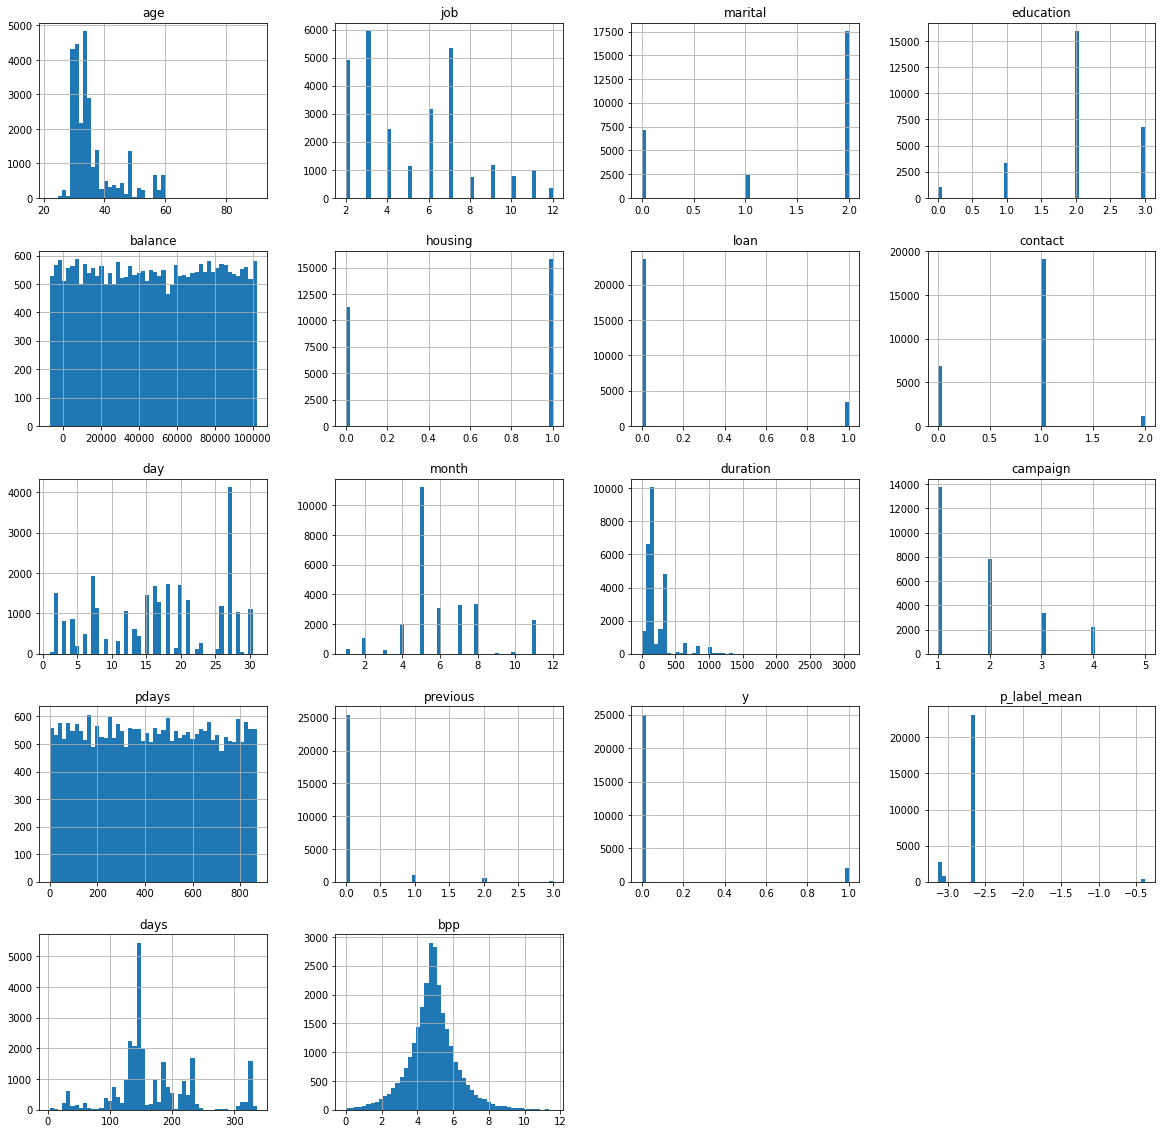

In [779]:
train_df.hist(bins=50, figsize=(20, 20))

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'job'}>,
        <AxesSubplot:title={'center':'marital'}>,
        <AxesSubplot:title={'center':'education'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'housing'}>,
        <AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'contact'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'p_label_mean'}>,
        <AxesSubplot:title={'center':'days'}>],
       [<AxesSubplot:title={'center':'bpp'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

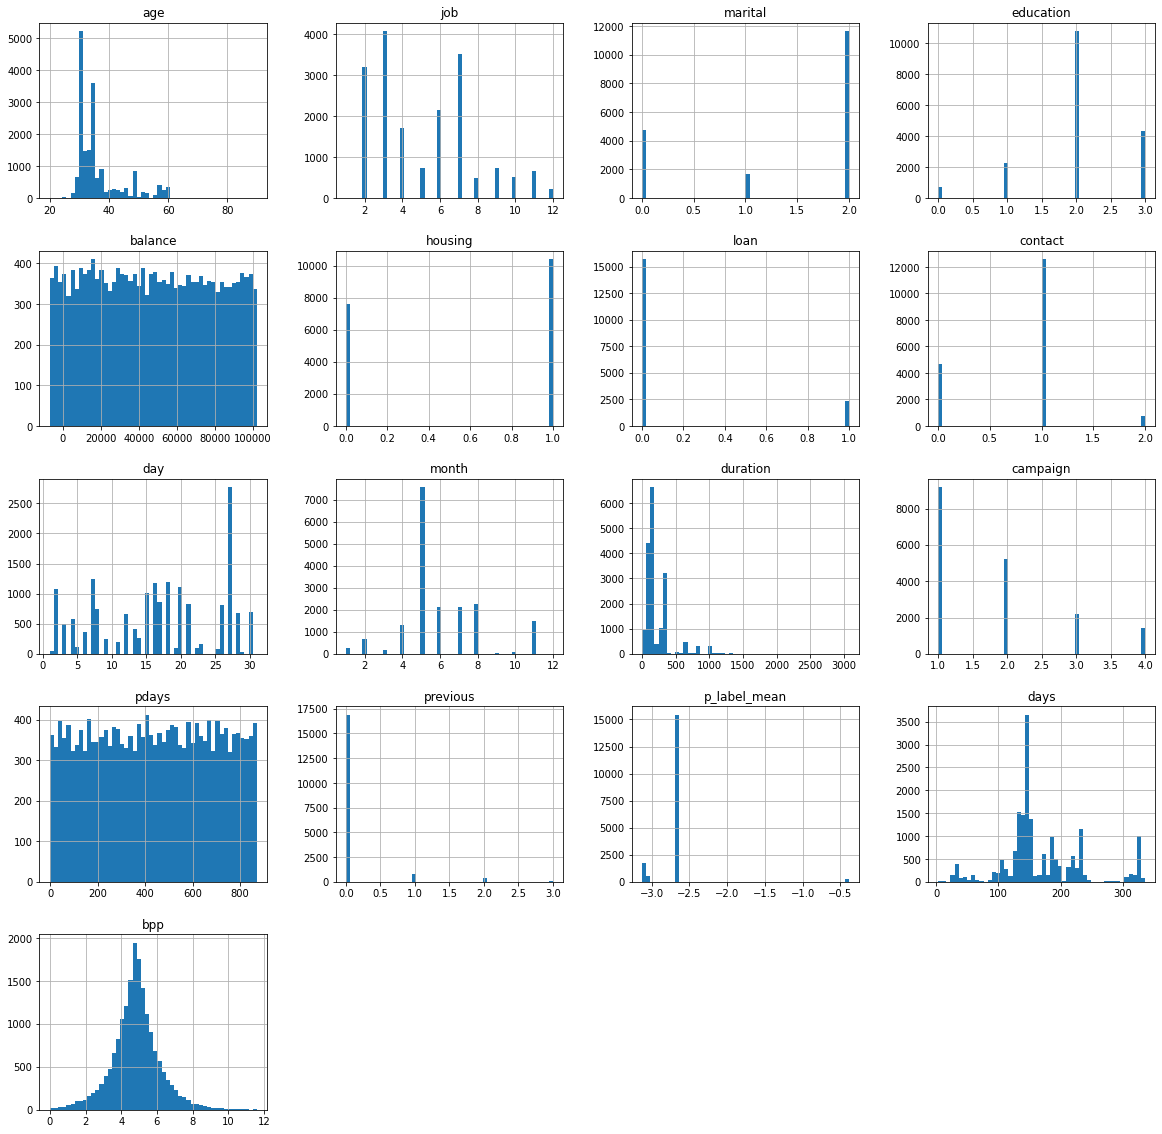

In [780]:
test_df.hist(bins=50, figsize=(20, 20))

## 学習準備

In [781]:
y = train_df.pop('y')

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=11)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)

## ハイパーパラメータ

In [782]:
lgb_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15
}

## 学習

In [783]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    verbose_eval=100
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

[100]	Train's binary_logloss: 0.21106	Test's binary_logloss: 0.217422
[200]	Train's binary_logloss: 0.193941	Test's binary_logloss: 0.206287
[300]	Train's binary_logloss: 0.175685	Test's binary_logloss: 0.197747
[400]	Train's binary_logloss: 0.168962	Test's binary_logloss: 0.196677
[500]	Train's binary_logloss: 0.156587	Test's binary_logloss: 0.194354
[600]	Train's binary_logloss: 0.144044	Test's binary_logloss: 0.193189
[700]	Train's binary_logloss: 0.13909	Test's binary_logloss: 0.193425
[800]	Train's binary_logloss: 0.13049	Test's binary_logloss: 0.192734
[900]	Train's binary_logloss: 0.12391	Test's binary_logloss: 0.193432
[1000]	Train's binary_logloss: 0.115712	Test's binary_logloss: 0.194118
Result:
{'boosting': 'dart', 'application': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.05, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'num_leaves': 41, 'drop_rate': 0.15}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('binary_logloss', 0.11571236155

## 可視化

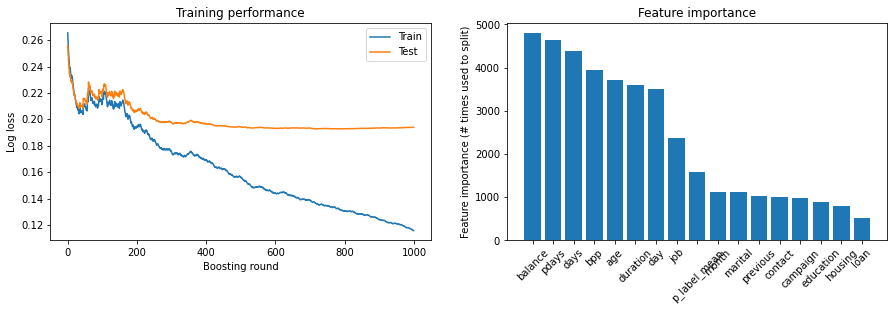

In [784]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [785]:
importances.sort_values('importance')

,features,importance
6,loan,510
5,housing,802
3,education,887
11,campaign,978
7,contact,1000
13,previous,1035
2,marital,1121
9,month,1122
14,p_label_mean,1592
1,job,2373


In [786]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9346863468634686
Precision score = 	 0.7378640776699029
Recall score =   	 0.18858560794044665
F1 score =      	 0.30039525691699603


## 推論

In [787]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [788]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)

In [789]:
#pseudo labeling

#test_df['y'] = test_pred
#test_df.to_csv('test_p1.csv', index=False)